This project explores a dynamic pair trading strategy using Bayesian optimization for Z-score thresholds. It includes cointegration analysis, Bollinger Band-based signals, and backtesting. Our aim is to identify effective parameter combinations for maximizing risk-adjusted returns while leveraging technical and statistical tools.


**Installing Libraries**

In [3]:
!pip install yfinance pandas-ta matplotlib plotly scikit-learn bayesian-optimization stable-baselines3 ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.0 MB/s eta 0:00:00
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=3881a39aa110ebdc71c85f40330c43809a81c70d275e705dec1d7956fe5c5dcf
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


**Importing Libraries**

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from statsmodels.tsa.stattools import coint
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import plotly.graph_objects as go

**Loading and Processing Data**

Here we will use *pandas-ta* to download historical stock prices and calculate technical indicators.

In [23]:
tickers = ['IMTX', 'COGT']
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Adj Close']
data = data.dropna()

data['RSI_IMTX'] = ta.rsi(data['IMTX'], length=14)
data['RSI_COGT'] = ta.rsi(data['COGT'], length=14)
data['SMA_IMTX'] = ta.sma(data['IMTX'], length=20)
data['SMA_COGT'] = ta.sma(data['COGT'], length=20)
data['VOL_IMTX'] = ta.volatility(data['IMTX'], length=14)
data['VOL_COGT'] = ta.volatility(data['COGT'], length=14)

data = data.dropna()

[*********************100%***********************]  2 of 2 completed


**Testing for Cointegration**

Here, we will perform the Engle-Granger cointegration test to identify pairs suitable for pair trading.

In [25]:
def find_cointegrated_pairs(data):
    pairs = []
    for i in range(len(data.columns)):
        for j in range(i + 1, len(data.columns)):
            asset1, asset2 = data.columns[i], data.columns[j]
            coint_t, p_value, _ = coint(data[asset1], data[asset2])
            if p_value < 0.05:  # cointegration threshold
                pairs.append((asset1, asset2, p_value))
    return pairs

cointegrated_pairs = find_cointegrated_pairs(data[['IMTX', 'COGT']])
print("Cointegrated pairs:", cointegrated_pairs)

Cointegrated pairs: [('IMTX', 'COGT', 0.014708760477556192)]


**Calculating Spread and Dynamic Hedge Ratio**

In [26]:
def optimize_hedge_ratio(asset1, asset2):
    def spread_variance(hedge_ratio):
        spread = asset1 - hedge_ratio * asset2
        return np.var(spread)
    result = minimize(spread_variance, x0=1)
    return result.x[0]

pair = cointegrated_pairs[0]
hedge_ratio = optimize_hedge_ratio(data[pair[0]], data[pair[1]])
data['Spread'] = data[pair[0]] - hedge_ratio * data[pair[1]]

**Generating Signals with Dynamic Threshold**

Here we will use *pandas-ta* to calculate Bollinger Bands and generate trading signals.

In [27]:
bbands = ta.bbands(data['Spread'], length=20, std=2)
data['Spread_Mean'] = bbands['BBM_20_2.0']
data['Upper_Band'] = bbands['BBU_20_2.0']
data['Lower_Band'] = bbands['BBL_20_2.0']

data['Z-Score'] = (data['Spread'] - data['Spread_Mean']) / (data['Upper_Band'] - data['Lower_Band'])
data['Long'] = data['Z-Score'] < -2
data['Short'] = data['Z-Score'] > 2
data['Exit'] = (data['Z-Score'] > -0.5) & (data['Z-Score'] < 0.5)

**Backtesting with Transaction Costs**

In [28]:
transaction_cost = 0.001

data['Position'] = 0
data.loc[data['Long'], 'Position'] = 1
data.loc[data['Short'], 'Position'] = -1
data['Position'] = data['Position'].ffill().fillna(0)

returns = data[['IMTX', 'COGT']].pct_change().dropna()
portfolio_returns = (
    data['Position'][:-1] * (returns[pair[0]] - hedge_ratio * returns[pair[1]])[1:]
)
portfolio_returns -= transaction_cost * data['Position'].diff().abs()

data['Cumulative_Returns'] = (1 + portfolio_returns).cumprod()

**Bayesian Optimization for Thresholds**

Here we will optimize *Z-score* thresholds dynamically.

|   iter    |  target   |   lower   |   upper   |
-------------------------------------------------
| 1         | -0.3726   | -1.125    | 1.451     |
| 2         | -0.3607   | -0.768    | 1.099     |
| 3         | -0.3387   | -1.344    | 0.656     |
| 4         | -0.3688   | -1.442    | 1.366     |
| 5         | -0.3728   | -0.8989   | 1.208     |
| 6         | -0.3623   | -1.479    | 1.47      |
| 7         | -0.3332   | -0.6676   | 0.7123    |
| 8         | -0.348    | -1.318    | 0.6834    |
| 9         | -0.3665   | -1.196    | 1.025     |
| 10        | -0.3518   | -1.068    | 0.7912    |
| 11        | -0.3319   | -0.718    | 0.6666    |
| 12        | -0.3322   | -1.456    | 0.5401    |
| 13        | -0.3459   | -1.304    | 0.5025    |
| 14        | -0.3356   | -1.497    | 0.6998    |
| 15        | -0.3228   | -0.5736   | 0.518     |
| 16        | -0.3205   | -0.5005   | 0.6462    |
| 17        | -0.3797   | -1.058    | 1.324     |
| 18        | -0.3373   | -0.8507   | 0.5011    |


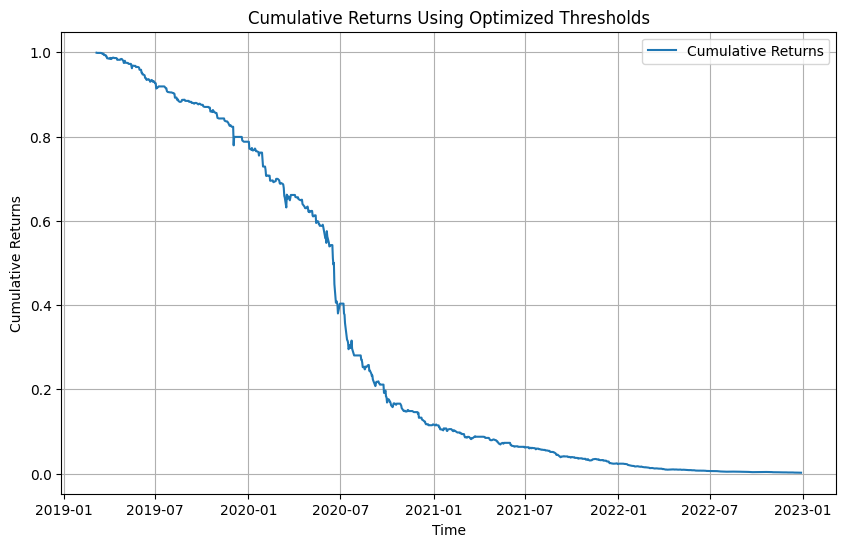

In [36]:
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def optimize_hedge_ratio(asset1, asset2):
    def spread_variance(hedge_ratio):
        spread = asset1 - hedge_ratio * asset2
        return np.var(spread)
    result = minimize(spread_variance, x0=1)
    return result.x[0]

def optimize_thresholds(lower, upper):
    data['Long'] = data['Z-Score'] < lower
    data['Short'] = data['Z-Score'] > upper
    data['Position'] = 0
    data.loc[data['Long'], 'Position'] = 1
    data.loc[data['Short'], 'Position'] = -1
    data['Position'] = data['Position'].ffill().fillna(0)

    portfolio_returns = (
        data['Position'][:-1] * (returns['IMTX'] - hedge_ratio * returns['COGT'])[1:]
    )

    portfolio_returns = portfolio_returns[portfolio_returns.between(
        portfolio_returns.quantile(0.01), portfolio_returns.quantile(0.99)
    )]

    if portfolio_returns.empty or portfolio_returns.std() == 0 or portfolio_returns.isna().any():
        return -1.0  # penalizing invalid results

    # return sharpe ratio
    return portfolio_returns.mean() / portfolio_returns.std()


data = data.dropna()

volatility_window = 20
data['Z-Score'] = (
    data['Spread'] - data['Spread'].rolling(window=volatility_window).mean()
) / data['Spread'].rolling(window=volatility_window).std()
data = data.dropna()

pbounds = {
    'lower': (-1.5, -0.5),
    'upper': (0.5, 1.5),
}

optimizer = BayesianOptimization(
    f=optimize_thresholds,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=10, n_iter=100)

optimal_params = optimizer.max
print("Optimal thresholds:", optimal_params)

optimal_lower = optimal_params['params']['lower']
optimal_upper = optimal_params['params']['upper']

data['Long'] = data['Z-Score'] < optimal_lower
data['Short'] = data['Z-Score'] > optimal_upper
data['Position'] = 0
data.loc[data['Long'], 'Position'] = 1
data.loc[data['Short'], 'Position'] = -1
data['Position'] = data['Position'].ffill().fillna(0)

portfolio_returns = (
    data['Position'][:-1] * (returns['IMTX'] - hedge_ratio * returns['COGT'])[1:]
)
portfolio_returns = portfolio_returns[portfolio_returns.between(
    portfolio_returns.quantile(0.01), portfolio_returns.quantile(0.99)
)]
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title("Cumulative Returns Using Optimized Thresholds")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

The consistent decline in cumulative returns indicates a strategy that fails to generate positive performance. The absence of upward trends or stabilization suggests that the chosen thresholds and underlying strategy parameters may not effectively capture profitable opportunities in the market.

**Z-Score Distribution**

Here we are visualizing the distribution of Z-scores to ensure they follow a mean-reverting pattern.

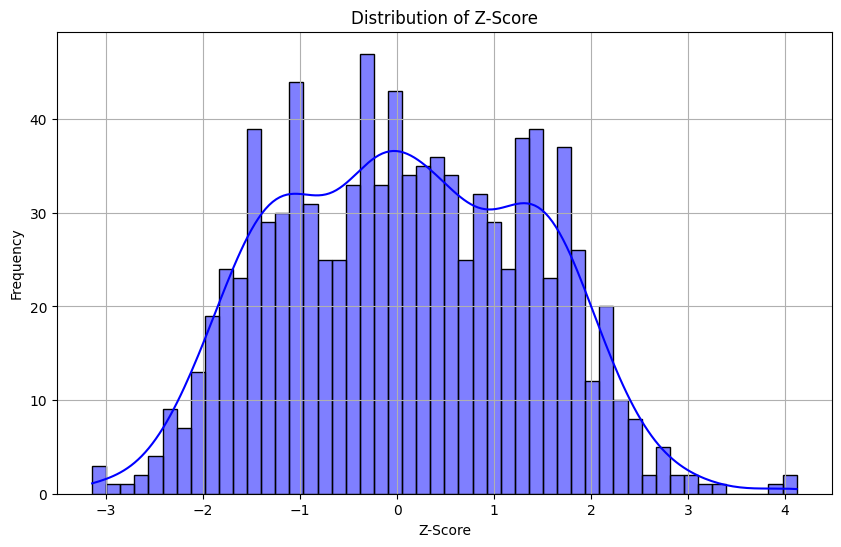

In [37]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['Z-Score'], bins=50, kde=True, color='blue')
plt.title('Distribution of Z-Score')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The distribution centers around zero, reflecting the mean-reverting behavior of the spread. This supports the assumption of normality in the spread's behavior, which is essential for strategies relying on Z-score thresholds. The tails of the distribution indicate less frequent, extreme deviations that could represent high-risk trading opportunities.

**Spread Plot**

Here we are visualizing the spread between the two assets and overlay the Bollinger Bands to see how well the thresholds align with the mean reversion.

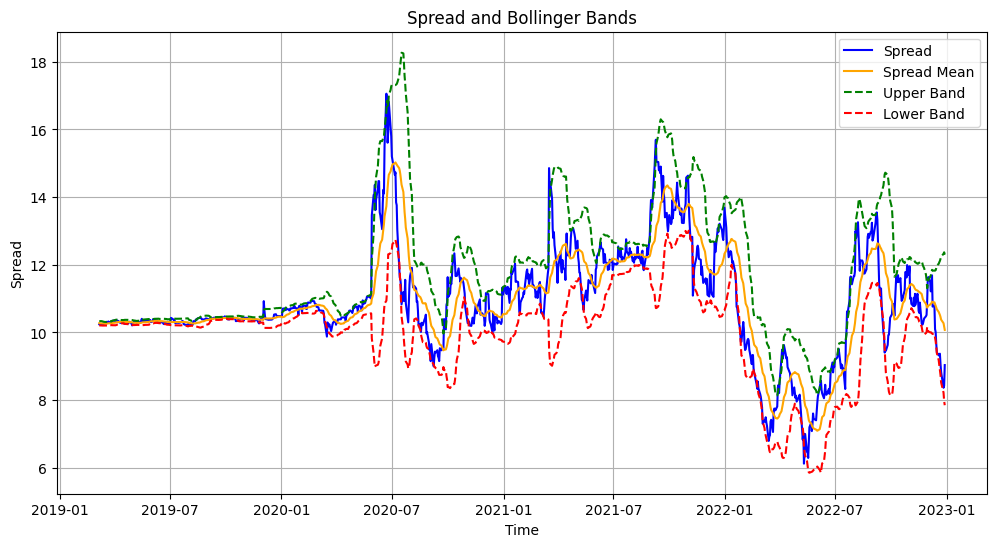

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Spread'], label='Spread', color='blue')
plt.plot(data.index, data['Spread_Mean'], label='Spread Mean', color='orange')
plt.plot(data.index, data['Upper_Band'], label='Upper Band', color='green', linestyle='--')
plt.plot(data.index, data['Lower_Band'], label='Lower Band', color='red', linestyle='--')
plt.title('Spread and Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid()
plt.show()

The interaction of the spread with the Bollinger Bands elucidates key trading signals. When the spread approaches or breaches the upper band, it may indicate overbought conditions, while nearing the lower band suggests oversold conditions. This dynamic gives us a basis for potential entry and exit points in trading decisions.

**Heatmap of Optimization Results**

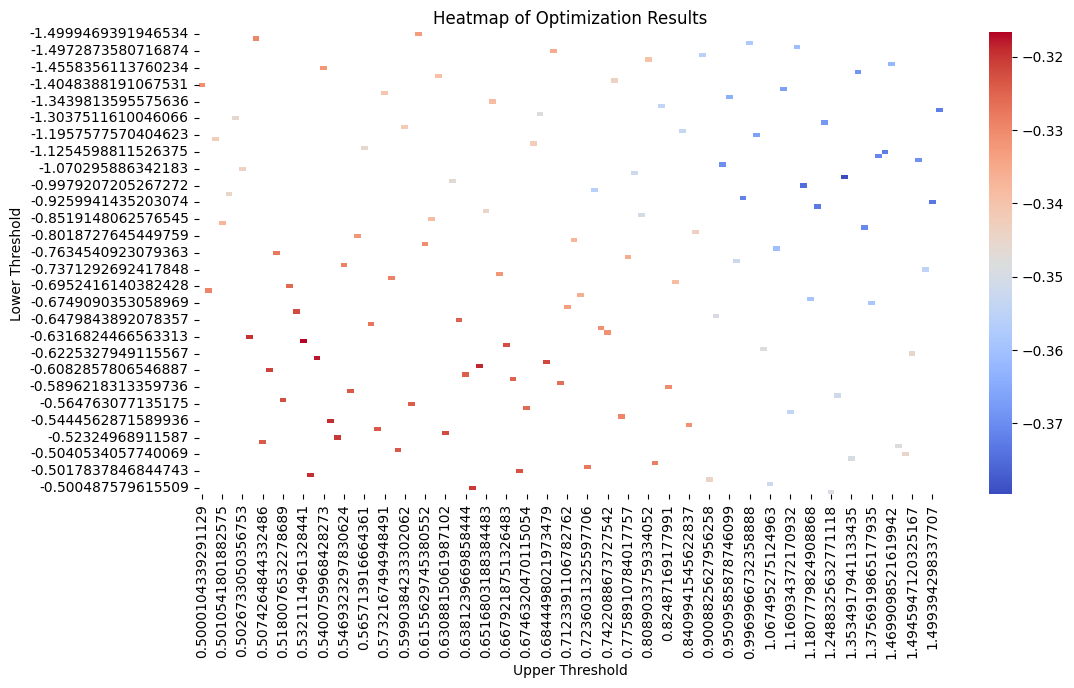

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

lower_values = [res['params']['lower'] for res in optimizer.res]
upper_values = [res['params']['upper'] for res in optimizer.res]
targets = [res['target'] for res in optimizer.res]

heatmap_data = pd.DataFrame({'Lower': lower_values, 'Upper': upper_values, 'Sharpe': targets})

heatmap_pivot = heatmap_data.pivot(index='Lower', columns='Upper', values='Sharpe')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=False)
plt.title('Heatmap of Optimization Results')
plt.xlabel('Upper Threshold')
plt.ylabel('Lower Threshold')
plt.show()

The heatmap identifies a few regions with relatively better performance, showing potential threshold combinations that could optimize risk-adjusted returns. That being said, the predominance of low-performing areas indicates the challenge of consistently finding effective threshold parameters.

**Conclusions**

Although our heatmap reveals certain combinations of thresholds with potential, the overall results—particularly the cumulative returns—highlight significant *underperformance*. The spread and Z-score analyses confirm predictable patterns in asset behavior, but the strategy's design does not appear to effectively translate these patterns into profits.

We must revisit the strategy’s assumptions and parameters. This may involve refining the threshold optimization process, exploring alternative trading rules, or selecting different asset pairs with stronger cointegration. Also, incorporating more robust risk management and adapting to market conditions may enhance the strategy's overall effectiveness.